In [1]:
!pip install split_folders

In [2]:
import splitfolders

In [3]:
import numpy as np 
import pandas as pd 
import time
import itertools

import os
import os.path
from   os import path
import shutil

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3


In [4]:
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [5]:
FOLDERS     = ['train','val','test']
DIR_INPUT   = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
DIR_WORK    = './'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']

SEED        = 1999
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [6]:
def create_dir(dir_path,folder,verbose=True):
    msg = ""
    folder_path = os.path.join(dir_path,folder)
    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)
    return folder_path
create_dir(DIR_WORK,'models',True)

./models created


'./models'

In [7]:
def resample_train_val_images(input_dir,working_dir,seed=SEED,split = (0.80,0.20)):
    dir_test   = os.path.join(input_dir,'test')
    dir_train  = os.path.join(input_dir,'train')
    for folder in FOLDERS:
        if path.exists(os.path.join(working_dir,folder)):
            shutil.rmtree(os.path.join(working_dir,folder))
            
    splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split)
    shutil.copytree(dir_test, os.path.join(working_dir,'test'))
    
resample_train_val_images(DIR_INPUT,DIR_WORK)

Copying files: 5121 files [00:28, 179.11 files/s]


In [8]:
IMG_SIZE = [176,208]
BATCH_SIZE = 32

train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)


train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',        
    seed        = SEED 
)

val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',        
    seed        = SEED
)

test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         
    seed        = SEED,
    shuffle     = False
)


Found 4095 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [9]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):

    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model will be Trainable:")
        base.trainable = False
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)
                    
                    

In [10]:
def build_transfer_model(conv_base,dropout,dense_node,learn_rate,metric):
    backend.clear_session()
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric ) 
    model.summary()
    return model

In [11]:
EPOCHS        = 25
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 5,restore_best_weights=True, verbose=1)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]

2022-06-06 05:50:12.797008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 05:50:12.998254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 05:50:12.999512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 05:50:13.001267: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))
freeze_layers(conv_base,trainable_layers='none')
model = build_transfer_model(conv_base,dropout=0.4,dense_node =512,learn_rate=0.001,metric=metrics)
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
   # callbacks        = callbacks  
)



87924736/87910968 [==============================] - 3s 0us/step
No Layers Trainable: Using Base Model Weights


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 5, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               20972032  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 42,785,060
Trainable params: 20,978,180
Non-trainable params: 21,806,880
___________________________________

2022-06-06 05:50:24.260563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-06-06 05:50:31.628292: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 - 27s - loss: 2.2309 - auc: 0.8184 - val_loss: 0.7320 - val_auc: 0.9093
Epoch 2/25
128/128 - 9s - loss: 0.6335 - auc: 0.9251 - val_loss: 0.7110 - val_auc: 0.9076
Epoch 3/25
128/128 - 9s - loss: 0.4618 - auc: 0.9617 - val_loss: 0.5216 - val_auc: 0.9510
Epoch 4/25
128/128 - 9s - loss: 0.3367 - auc: 0.9796 - val_loss: 0.4564 - val_auc: 0.9627
Epoch 5/25
128/128 - 9s - loss: 0.2498 - auc: 0.9886 - val_loss: 0.3736 - val_auc: 0.9750
Epoch 6/25
128/128 - 9s - loss: 0.1912 - auc: 0.9933 - val_loss: 0.3719 - val_auc: 0.9745
Epoch 7/25
128/128 - 10s - loss: 0.1630 - auc: 0.9949 - val_loss: 0.4961 - val_auc: 0.9639
Epoch 8/25
128/128 - 9s - loss: 0.1506 - auc: 0.9956 - val_loss: 0.4467 - val_auc: 0.9667
Epoch 9/25
128/128 - 10s - loss: 0.1207 - auc: 0.9964 - val_loss: 0.3471 - val_auc: 0.9791
Epoch 10/25
128/128 - 10s - loss: 0.1085 - auc: 0.9976 - val_loss: 0.4403 - val_auc: 0.9697
Epoch 11/25
128/128 - 10s - loss: 0.0872 - auc: 0.9983 - val_loss: 0.3433 - val_auc: 0.9791
Epoch 12/25
12

In [13]:
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

y_actual = test_gen.classes



 Model AUC on Test Data:81.0%
------------------------------
              precision    recall  f1-score   support

        mild       0.83      0.11      0.19       179
    moderate       1.00      0.08      0.15        12
      normal       0.63      0.88      0.73       640
   very-mild       0.58      0.47      0.52       448

    accuracy                           0.62      1279
   macro avg       0.76      0.38      0.40      1279
weighted avg       0.64      0.62      0.58      1279



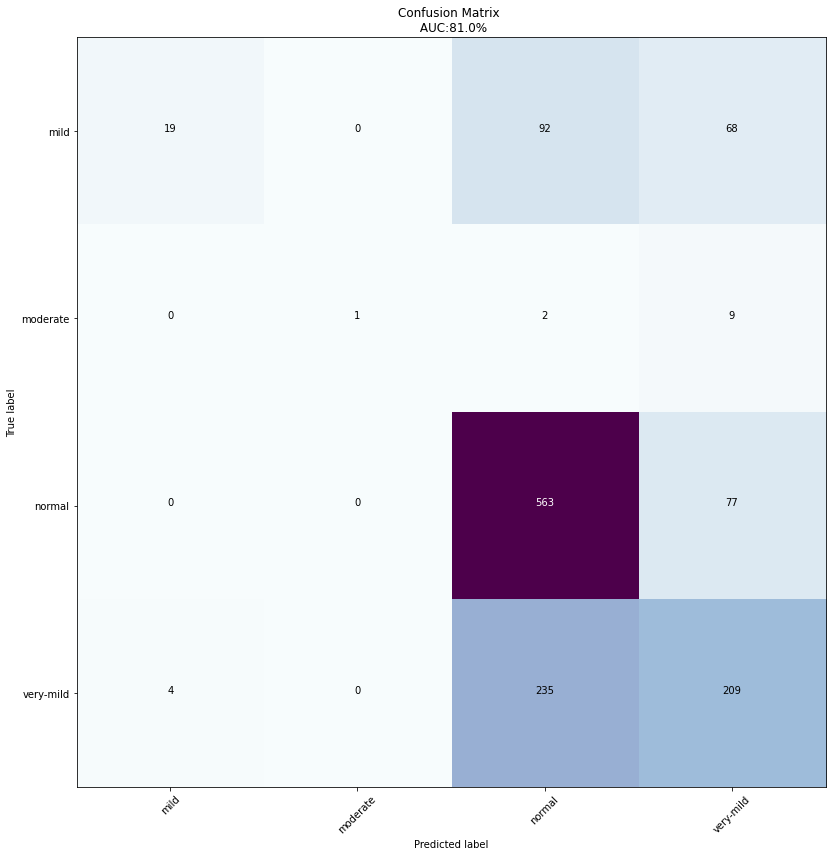

In [14]:
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):

    test_loss, test_metric = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100 
    results_title ="\n Model AUC on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")
    
    print(classification_report(y_actual, y_pred, target_names=classes))

    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    plt.subplots(figsize=(12,12))
    cm = confusion_matrix(y_actual, y_pred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

In [15]:
model.save(os.path.join(DIR_MODELS,'base_model'))

2022-06-06 05:55:36.590496: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [16]:
imported = tf.saved_model.load('./models/base_model')

In [17]:
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

y_actual = test_gen.classes

In [18]:
for i in range(0,10):
    print('Predicted Class:  '+CLASS_LIST[y_pred[i]]+'                   Actual Class:  ' + CLASS_LIST[y_actual[i]])

Predicted Class:  NonDememted                   Actual Class:  MildDememted
Predicted Class:  NonDememted                   Actual Class:  MildDememted
Predicted Class:  MildDememted                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  NonDememted                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  MildDememted                   Actual Class:  MildDememted
Predicted Class:  NonDememted                   Actual Class:  MildDememted
Predicted Class:  MildDememted                   Actual Class:  MildDememted
